# Get Reviews - Find common clients complains

In [94]:
import feedparser
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import string

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords 


stop_words = set(stopwords.words('english'))
additional_words = ['i','on','t', 'a', 've', 'been', 'is', 'are', 'we', 'were', 'was', 'at', 'android', 'downloaded', 'palatine']
new_stopwords = stop_words.union(additional_words)
new_stopwords.remove('can')

%matplotlib inline

### Apple Store

In [95]:
url = 'https://itunes.apple.com/gb/rss/customerreviews/id=705079381/sortBy=mostRecent/xml'

rss = feedparser.parse(url)

In [96]:
totalReviews = len(rss.entries)

full_content = [rss.entries[nReviews]['content'] for nReviews in range(totalReviews)]
content_apple = [full_content[nReviews][0].value.replace("   Full Review","").replace("'", "").lower() for nReviews in range(totalReviews)]

rating_apple = [int(rss.entries[nReviews]['im_rating']) for nReviews in range(totalReviews)]

platform_apple = ["iOS" for platform in range(len(content_apple))]

### Google Play Store

In [97]:
!ls

GUG - Get Reviews.ipynb               config.pyc
com.getyourguide.android_decoded.html getReviews.py
config.py


In [98]:
soup = BeautifulSoup(open('com.getyourguide.android_decoded.html'), 'html.parser')

In [99]:
full_rating = soup.find_all(attrs={'class':'tiny-star star-rating-non-editable-container'})
rating_with_text = [rating['aria-label'] for rating in full_rating]
rating_google = [int(rating.split()[1]) for rating in rating_with_text]


full_content = soup.find_all(attrs={'class':'review-body with-review-wrapper'})
content_google = [content.get_text().strip().replace("   Full Review","").replace("'", "").lower() for content in full_content]

platform_google = ["Android" for platform in range(len(content_google))]

### Total Reviews

In [100]:
final_rating = rating_google
final_rating.extend(rating_apple)


final_content = content_google
final_content.extend(content_apple)

final_platform = platform_google
final_platform.extend(platform_apple)


fullList = {'Content':final_content, 'Rating': final_rating, 'Platform': final_platform}

In [101]:
df = pd.DataFrame(fullList, columns=['Content', 'Rating', 'Platform'])

In [102]:
df_bad_reviews = df[df.Rating<=2]

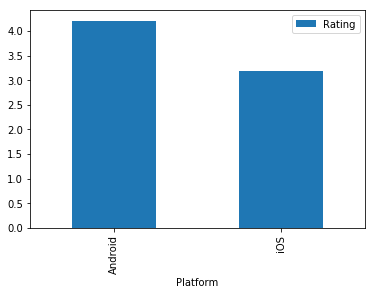

In [103]:
df.groupby('Platform').agg({'Rating':'mean'}).plot(kind='bar')

#### BOW for general and lower rating reviews - Simplistic sentiment analysis

In [104]:
used_df = df_bad_reviews
#used_df = df

sentences = [content for content in used_df.Content] 

In [105]:
def generate_ngrams(s, n):
    s = s.lower()
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
    token = [token for token in s.split(" ") if token != ""]

    
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [106]:
# Filter non relevant words and lowercasing
filtered_sentences = []

for x in range(len(sentences)):
    word_tokens = sentences[x].split()
    filtered_sentences.append(" ".join(filter(lambda x: x not in (new_stopwords or string.punctuation), word_tokens)).lower())

In [107]:
# Buid dict with occurences into a dataframe
final_tokens = []
for i in range(len(filtered_sentences)):
    final_tokens.extend(generate_ngrams(filtered_sentences[i], 3))

word_dict = dict.fromkeys(final_tokens, 0)

for word in final_tokens:
    word_dict[word]+=1

In [108]:
# Comput TF & IDF
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

tf = computeTF(word_dict, final_tokens)

def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

idf = computeIDF([word_dict])

def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

tf_idf = computeTFIDF(tf, idf)

#### Lets analyze only TF for simplification

In [109]:
tf_df = pd.DataFrame([tf])

In [110]:
tf_df_transposed = tf_df.T
tf_df_transposed.reset_index(inplace=True)
tf_df_transposed.columns = ['words', 'score']

In [111]:
tf_df_transposed.sort_values(by=['score'], ascending=False)

,words,score
1629,guide never showed,0.000762
3831,worst customer service,0.000762
305,app looks ok,0.000508
292,app get tickets,0.000508
1986,looks ok im,0.000508
837,connection relying show,0.000508
2707,relying show vouchers,0.000508
835,confirming itinerary trips,0.000508
2077,might internet connection,0.000508
875,couldnt even find,0.000508


In [112]:
df_bad_reviews.Content

0      the prices are much higher than the actual pri...
5      you simply cannot change the e-mail address if...
17                            doesnt download my tickets
36     feedback application bugged, spamming with not...
49     if have - stars i will give it..... confirm my...
79          only gbp currency, u cannot change to othera
81                                         a descent app
85     had a sucessful purchase. 2nd purchase had a 2...
86     my booking before i purchased said audio guide...
89     awful. i had prepaid tics with all info on my ...
95                                worst experience ever.
141    tried to make booking, but the payment page on...
143    total scam! tour bus did not show up, and they...
166    non comprate biglietti da questa app. vi consi...
175    the guide never showed up to take my mom and h...
177    scam tour companies use this app/website to ri...
179    short version - do not trust these shysters wi...
180    frod! i bought tickets f